# Manual Feature Creation and Selection

In [1994]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer

import statsmodels.api as sm

In [1995]:
# Reading in the cleaned datasets from notebook 2.1
training = pd.read_csv('./datasets/clean_training.csv', index_col=0)
test = pd.read_csv('./datasets/clean_test.csv', index_col=0)

There are many different ways to approach feature selection. In this project, I use common knowledge of the housing market to manually select features that, I believe, will gainfully contribute to my model. I will explore, test and manipulate features. 

In [1996]:
# Listing features for examination and contemplation.
list(training.columns)

['ms_zoning',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 'kitchen_qual',
 'functional',
 'fireplace_qu',
 'garage_type',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'pool_qc',
 'fence',
 'misc_feature',
 'sale_type',
 'id',
 'pid',
 'ms_subclass',
 'lot_frontage',
 'lot_area',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod/add',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvg

In [1997]:
# Making total_bath feature 
training['total_bath'] = training['bsmt_full_bath'] + \
                         0.5 * training['bsmt_half_bath'] + \
                         training['full_bath'] + \
                         0.5 * training['half_bath']

test['total_bath'] = test['bsmt_full_bath'] + \
                         0.5 * test['bsmt_half_bath'] + \
                         training['full_bath'] + \
                         0.5 * test['half_bath']


In [1998]:
# Mapping exter_quality
training['exter_qual'].replace({
                        'Po': 1,
                        'Fa': 2,
                        'TA': 3,
                        'Gd': 4,
                        'Ex': 5},
                        inplace=True
)

test['exter_qual'].replace({
                    'Po': 1,
                    'Fa': 2,
                    'TA': 3,
                    'Gd': 4,
                    'Ex': 5},
                    inplace=True
)

In [1999]:
# Mapping kitchen_qual
training['kitchen_qual'].replace({
                            'Po': 1,
                            'Fa': 2,
                            'TA': 3,
                            'Gd': 4,
                            'Ex': 5},
                        inplace=True
)

test['kitchen_qual'].replace({
                        'Po': 1,
                        'Fa': 2,
                        'TA': 3,
                        'Gd': 4,
                        'Ex': 5},
                    inplace=True
)

In [2000]:
# Creating columns for all sqft and all floor sqft
training['all_sf'] = training['gr_liv_area'] + training['total_bsmt_sf']
training['all_flr_sf'] = training['1st_flr_sf'] + training['2nd_flr_sf']

test['all_sf'] = test['gr_liv_area'] + test['total_bsmt_sf']
test['all_flr_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']

In [2001]:
# Creating a pool feature
training['pool'] = training['pool_qc'].apply(lambda x: 0 if x == 'none' else 1)

In [2002]:
# Creating a garage ratio
training['garage_ratio'] = training['garage_cars'] / training['garage_area']

## Additional EDA

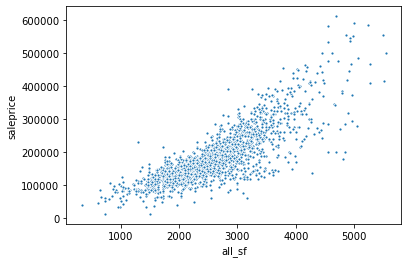

In [2003]:
# This looks linearly correlated. 
sns.scatterplot(training['all_sf'], training['saleprice'], marker='.');

In [2004]:
# Removing some outliers.
training = training[training['all_sf']<6000]

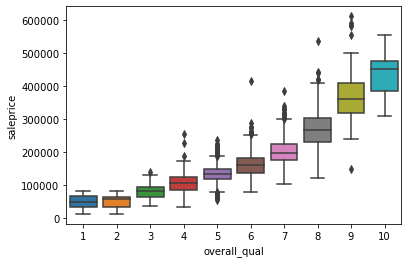

In [2005]:
# Reviewing the boxplots for overall quality and removing a few outliers from the dataset.
sns.boxplot(data=training, x='overall_qual', y='saleprice');

In [2006]:
training[(training['overall_qual'] == 9)  & (training['saleprice']<200000)]
training[(training['overall_qual'] == 6)  & (training['saleprice']>400000)]
training.drop([125, 1897], inplace=True)


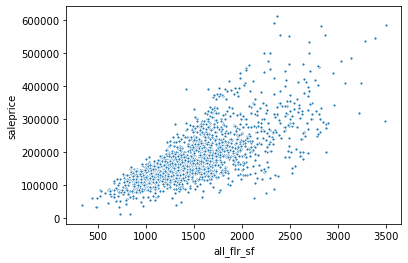

In [2007]:
# Reviewing all floor sqft vs sale price. Removing a few outliers.
sns.scatterplot(training['all_flr_sf'], training['saleprice'], marker='.');
training = training[training['all_flr_sf']<3200]

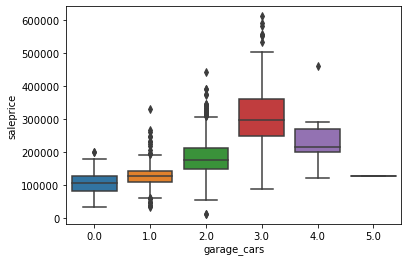

In [2008]:
# Reviewing the boxplots of garage cars. Determining the 5 car garage house may be an outlier. 
sns.boxplot(data=training, x='garage_cars', y='saleprice')
training = training[training['garage_cars'] != 5]

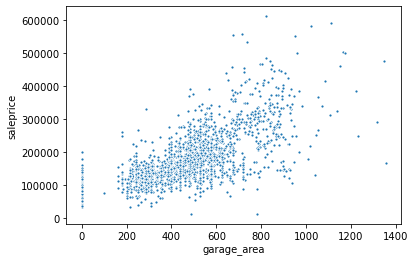

In [2009]:
# Checking the garage area vs saleprice. NaNs were originally assigned to 0. Reassinging to the mean 
sns.scatterplot(training['garage_area'], training['saleprice'], marker='.');
training['garage_area'] = training['garage_area'].apply(lambda x: training['garage_area'].mean() if x == 0 else x)
test['garage_area'] = test['garage_area'].apply(lambda x: training['garage_area'].mean() if x == 0 else x)

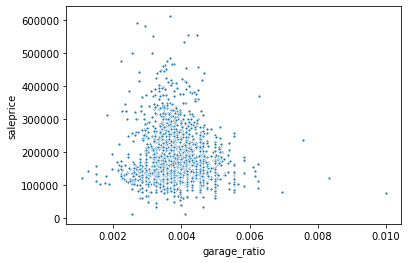

In [2010]:
# Checking the new feature garage ratio. There does not seem to be a strong correlation. There are a few outlier points, however. I will test removing them from the dataset.
sns.scatterplot(training['garage_ratio'], training['saleprice'], marker='.');
training[training['garage_ratio'] > .0065].sort_values(by='garage_ratio', ascending=False)
training.drop([873, 554], inplace=True)

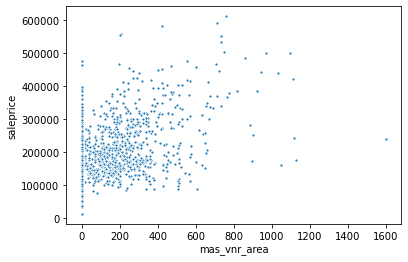

In [2011]:
# Checking masonry vaneer area and removing one outlier
sns.scatterplot(training['mas_vnr_area'], training['saleprice'], marker='.');
training = training[training['mas_vnr_area'] < 1400]

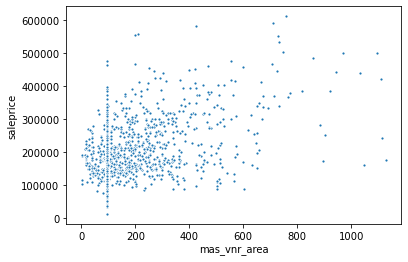

In [2012]:
# Moving the masonry vaneer NaNs to the mean.
training['mas_vnr_area'] = training['mas_vnr_area'].apply(lambda x: training['mas_vnr_area'].mean() if x == 0 else x)
test['mas_vnr_area'] = test['mas_vnr_area'].apply(lambda x: training['mas_vnr_area'].mean() if x == 0 else x)

sns.scatterplot(training['mas_vnr_area'], training['saleprice'], marker='.');

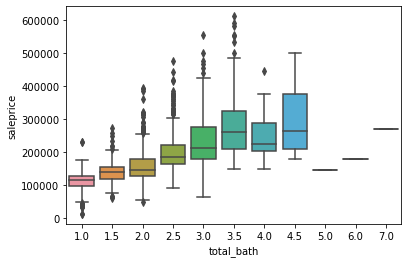

In [2013]:
sns.boxplot(data=training, x='total_bath', y='saleprice');

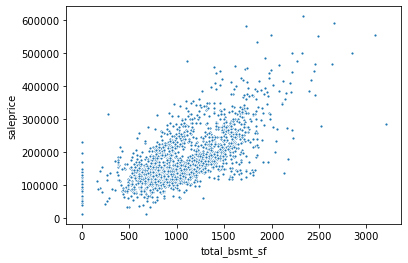

In [2014]:
# Reviewing total basement sqft. Removing outlier and assigning NaNs to the mean. 
sns.scatterplot(training['total_bsmt_sf'], training['saleprice'], marker='.');
training['total_bsmt_sf'] = training['total_bsmt_sf'].apply(lambda x: training['total_bsmt_sf'].mean() if x == 0 else x)
test['total_bsmt_sf'] = test['total_bsmt_sf'].apply(lambda x: training['total_bsmt_sf'].mean() if x == 0 else x)

training = training[training['total_bsmt_sf'] < 3000]


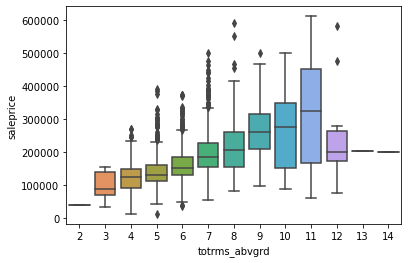

In [2015]:
# Reviewing the boxplots of total rooms above great. Removing data points with over 13 rooms.
sns.boxplot(data=training, x='totrms_abvgrd', y='saleprice');
training = training[training['totrms_abvgrd'] < 13]

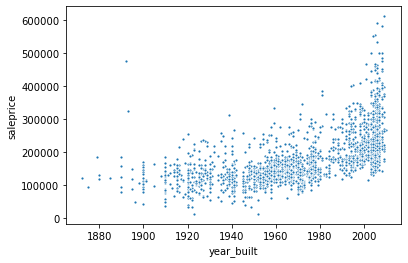

In [2016]:
# Year built vs sale price looks OK.
sns.scatterplot(training['year_built'], training['saleprice'], marker='.');

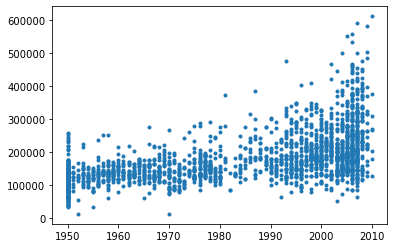

In [2017]:
# Noticing a large grouping around 1950. Will probably drop this column from my models.
plt.scatter(training['year_remod/add'], training['saleprice'], marker='.');


In [2018]:
# Detected a problem with NaNs in the test set. Fixing.
test['total_bath'].fillna(training['total_bath'].mean(), inplace=True)
test.isnull().sum()

ms_zoning       0
street          0
alley           0
lot_shape       0
land_contour    0
               ..
mo_sold         0
yr_sold         0
total_bath      0
all_sf          0
all_flr_sf      0
Length: 83, dtype: int64

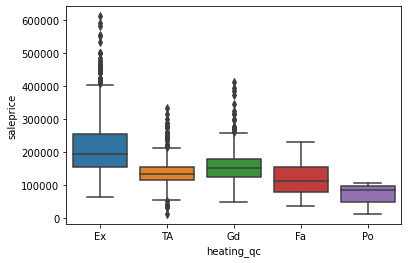

In [2019]:
# Reviewing boxplots of heating quality. Seems to be a correlation. 
sns.boxplot(data=training, x='heating_qc', y='saleprice');

In [2020]:
# Mapping heating quality to numeric.
training['heating_qc'] = \
            training['heating_qc'].replace({
                'Po': 0,
                'Fa': 1,
                'TA': 2,
                'Gd': 3,
                'Ex': 4
})

test['heating_qc'] = \
            test['heating_qc'].replace({
                'Po': 0,
                'Fa': 1,
                'TA': 2,
                'Gd': 3,
                'Ex': 4
})

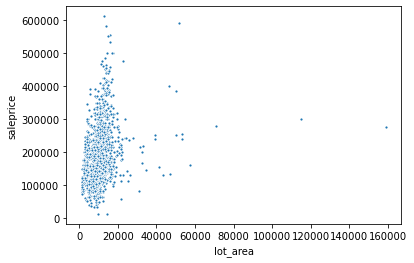

In [2021]:
# Reviewing lot area and removing a few outliers.
sns.scatterplot(data=training, x='lot_area', y='saleprice', marker='.');
training = training[training['lot_area']<60000]

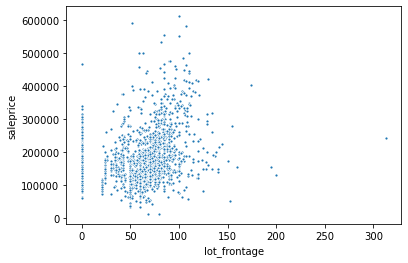

In [2022]:
# Reviewing lot frontage. Removing an outlier and assinging NaN's to the mean.
sns.scatterplot(data=training, x='lot_frontage', y='saleprice', marker='.')
training = training[training['lot_frontage']<200]
training['lot_frontage'] = training['lot_frontage'].apply(lambda x: training['lot_frontage'].mean() if x == 0 else x)
test['lot_frontage'] = test['lot_frontage'].apply(lambda x: training['lot_frontage'].mean() if x == 0 else x)


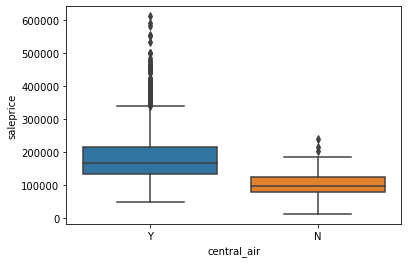

In [2023]:
# Reviewing boxplots of central air. Looks to be a correlation.
sns.boxplot(data=training, x='central_air', y='saleprice');
training['central_air'].replace({
    'N': 0, 
    'Y':1},
    inplace=True)
test['central_air'].replace({
    'N': 0, 
    'Y':1},
    inplace=True)

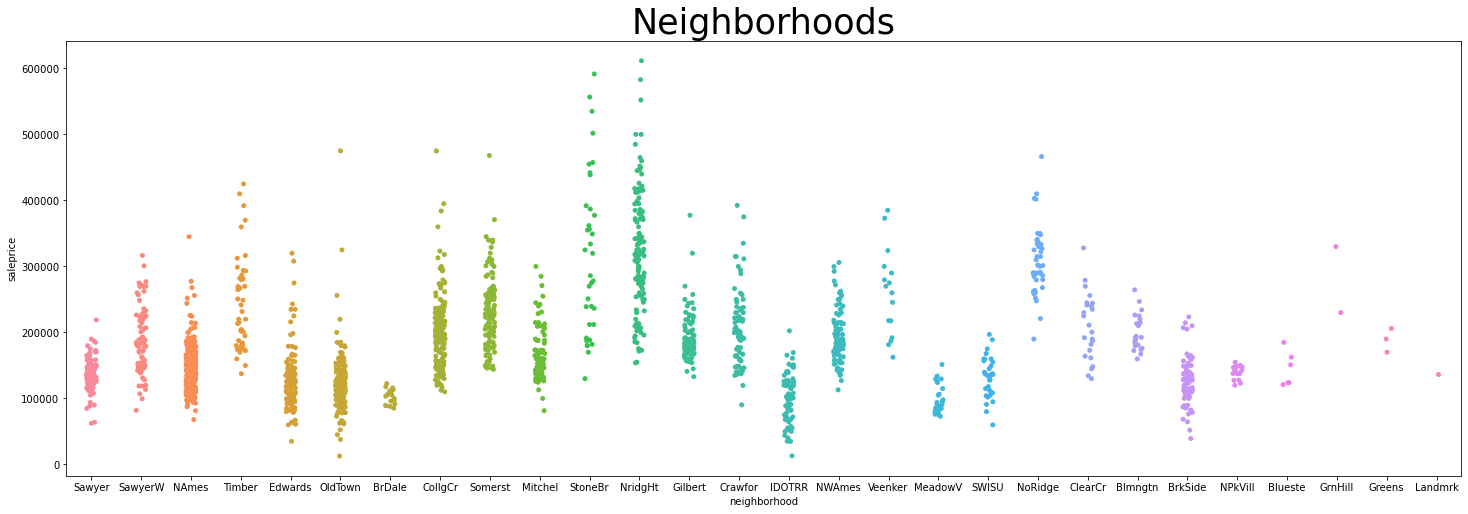

In [2024]:
# Inspiration came from Alvin T. Tan's article on medium https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96
# Creating a neighborhood desirability feature using the median housing price per neighborhood.
plt.figure(figsize=(25,8))
sns.stripplot(data=training, x='neighborhood', y='saleprice');
plt.title('Neighborhoods', fontsize=(35))
plt.savefig('./assets/Neighborhood Strip Plot')

In [2025]:
# Grouping training data by median saleprice per neighborhood.
training.groupby('neighborhood').saleprice.median().sort_values()

neighborhood
MeadowV     92450
IDOTRR     102388
BrDale     105500
OldTown    119950
Edwards    123000
BrkSide    128000
Sawyer     135000
SWISU      135900
Landmrk    137000
Blueste    137500
NAmes      141000
NPkVill    143000
Mitchel    160000
Gilbert    180750
SawyerW    181000
NWAmes     185000
Greens     190000
Blmngtn    192250
Crawfor    198750
CollgCr    200000
ClearCr    205750
Timber     220000
Somerst    223000
Veenker    265000
GrnHill    280000
NoRidge    291000
StoneBr    302950
NridgHt    317500
Name: saleprice, dtype: int64

In [2026]:
training['neighborhood'].replace({
                'MeadowV': 1,
                'IDOTRR': 1,
                'BrDale': 1,
                'OldTown': 1,
                'Edwards': 1,
                'BrkSide': 1,
                'Sawyer': 2,
                'SWISU': 2,
                'Landmrk': 2,
                'Blueste': 2,
                'NAmes': 2,
                'NPkVill': 2,
                'Mitchel': 2,
                'Gilbert': 3,
                'SawyerW': 3,
                'NWAmes': 3,
                'Greens': 3,
                'Blmngtn': 3,
                'Crawfor': 3,
                'CollgCr': 3,
                'ClearCr':  3,
                'Timber': 4,
                'Somerst': 4,
                'Veenker': 4,
                'GrnHill': 4,
                'NoRidge': 4,
                'StoneBr': 4,
                'NridgHt': 4},
        inplace = True)

test['neighborhood'].replace({
                'MeadowV': 1,
                'IDOTRR': 1,
                'BrDale': 1,
                'OldTown': 1,
                'Edwards': 1,
                'BrkSide': 1,
                'Sawyer': 2,
                'SWISU': 2,
                'Landmrk': 2,
                'Blueste': 2,
                'NAmes': 2,
                'NPkVill': 2,
                'Mitchel': 2,
                'Gilbert': 3,
                'SawyerW': 3,
                'NWAmes': 3,
                'Greens': 3,
                'Blmngtn': 3,
                'Crawfor': 3,
                'CollgCr': 3,
                'ClearCr':  3,
                'Timber': 4,
                'Somerst': 4,
                'Veenker': 4,
                'GrnHill': 4,
                'NoRidge': 4,
                'StoneBr': 4,
                'NridgHt': 4},
        inplace = True)

In [2027]:
# Detected one outlier. Removing it below
training[(training['neighborhood']==1) & (training['saleprice'] > 400000)]

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,...,pool_area,misc_val,mo_sold,yr_sold,saleprice,total_bath,all_sf,all_flr_sf,pool,garage_ratio
1035,RM,Pave,none,IR2,Lvl,AllPub,Inside,Gtl,1,Artery,...,0,0,6,2006,475000,2.5,4715.0,3036,0,0.003571


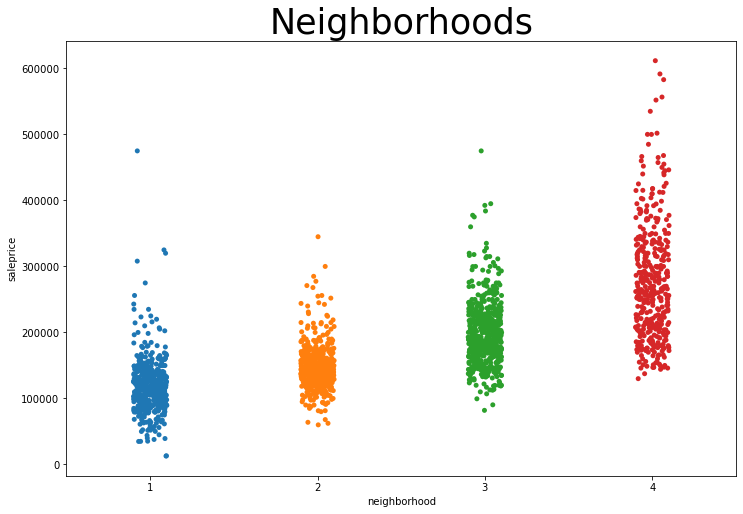

In [2028]:
# Checking to see if it maps well.
plt.figure(figsize=(12,8))
sns.stripplot(data=training, x='neighborhood', y='saleprice');
plt.title('Neighborhoods', fontsize=(35))
plt.savefig('./assets/Neighborhood Strip Plot Condensed')

In [2029]:
training.drop(1035, inplace=True)

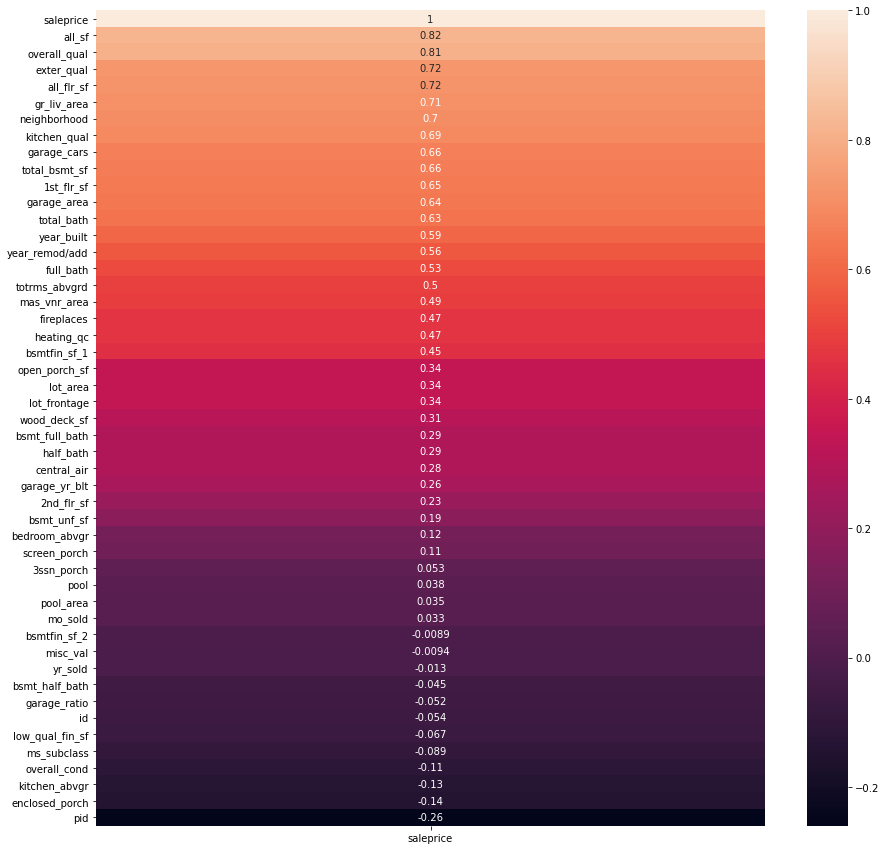

In [2030]:
# Checking correlations
plt.figure(figsize=(15, 15))
sns.heatmap(training.corr()[['saleprice']].sort_values(by='saleprice', ascending=False), annot=True);

In [2031]:
# Selecting Features
features = [#'all_sf',
            'overall_qual',  
            'exter_qual',
            'all_flr_sf', 
            #'gr_liv_area',
            'neighborhood',
            'kitchen_qual',
            #'garage_cars',
            'total_bsmt_sf', 
            #'1st_flr_sf',
            'garage_area',
            #'total_bath', 
            'year_built',
            'year_remod/add',
            'full_bath',
            #'totrms_abvgrd',
            'mas_vnr_area',
            'fireplaces', 
            'heating_qc',
            'bsmtfin_sf_1',
            #'open_porch_sf',
            'lot_area',
            'lot_frontage',
            #'central_air'
]

In [2032]:
# Statistcal Modeling using statsmodels and eliminating some features 
X = training[features]
y = training['saleprice']
ss = StandardScaler()
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1001.
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        21:19:33   Log-Likelihood:                -23430.
No. Observations:                2025   AIC:                         4.689e+04
Df Residuals:                    2008   BIC:                         4.699e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.258e+05   9.08e+04     -6.

In [2033]:
# Exporting enhanced feature datasets.
training.to_csv('./datasets/training_enhanced.csv')
test.to_csv('./datasets/test_enhanced.csv')